In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve

# 1 Harris Corner Detector

(300, 300)


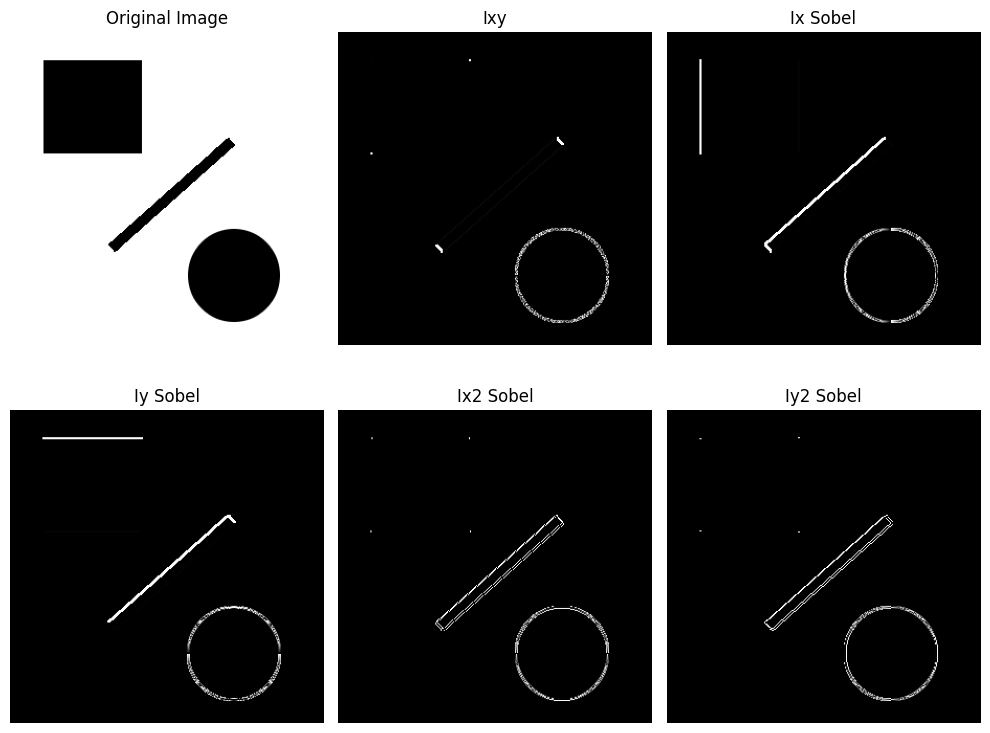

In [7]:

image = cv2.imread("Images/CircleLineRect.png", cv2.IMREAD_GRAYSCALE)

print(image.shape)


# Definition of Sobel Matrix
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]])


sobel_y2 = np.array([[1, 0, -1],
                    [-2, 0, 2],
                    [1, 0, -1]])

sobel_x2 = np.array([[1, -2, 1],
                    [0, 0, 0],
                    [-1,2,-1]])


#computing Ix and Iy
Ix_sobel = convolve(image, sobel_x)
Iy_sobel = convolve(image, sobel_y)

#computing Ix2 and Iy2
Ix2_sobel = convolve(image, sobel_x2)
Iy2_sobel = convolve(image, sobel_y2)

#Computing Ixy
Ixy_image = Ix_sobel * Iy_sobel


# Plot all figures
plt.figure(figsize=(10, 8))

# original image
plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

# Ixy
plt.subplot(2, 3, 2)
plt.title("Ixy")
plt.imshow(Ixy_image, cmap='gray')
plt.axis('off')

# Sobel X and Y
plt.subplot(2, 3, 3)
plt.title("Ix Sobel")
plt.imshow(Ix_sobel, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title("Iy Sobel")
plt.imshow(Iy_sobel, cmap='gray')
plt.axis('off')

#sobel Ix2 and Iy2
plt.subplot(2, 3, 5)
plt.title("Ix2 Sobel")
plt.imshow(Ix2_sobel, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title("Iy2 Sobel")
plt.imshow(Iy2_sobel, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


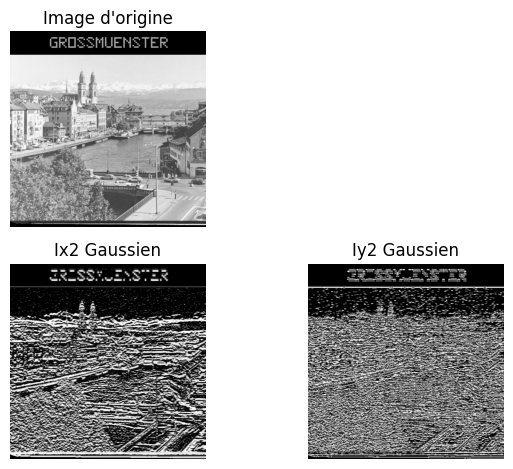

In [4]:
# Compute Ix and Ix with gaussian filter (alternative way)
sigma = 1  # Écart-type pour le filtre Gaussien
Ix_gaussian = gaussian_filter(image, sigma=sigma, order=(0, 1))  # Partial derivative in x
Iy_gaussian = gaussian_filter(image, sigma=sigma, order=(1, 0))  # Partial derivative in y

#Compute Ix2 smooth and Iy2 smooth using gaussian filter again
Ix2_smooth = gaussian_filter(Ix_gaussian, sigma=0.5, order=(0, 1))
Iy2_smooth = gaussian_filter(Iy_gaussian, sigma=0.5, order=(1, 0))

# Original Image
plt.subplot(2, 2, 1)
plt.title("Image d'origine")
plt.imshow(image, cmap='gray')
plt.axis('off')

# Ix2 Smooth
plt.subplot(2, 2, 3)
plt.title("Ix2 Gaussien")
plt.imshow(Iy_gaussian, cmap='gray')
plt.axis('off')

# Iy Gaussien
plt.subplot(2, 2, 4)
plt.title("Iy2 Gaussien")
plt.imshow(Iy2_smooth, cmap='gray')
plt.axis('off')



plt.tight_layout()
plt.show()


In [5]:
Ixy_conj = np.conj(Ix_gaussian*Iy_gaussian)
Ix2_sobel_conj = np.conj(Ix2_smooth)
Iy2_sobel_conj = np.conj(Iy2_smooth)
print(Ixy_conj.shape)
print(Ix2_sobel_conj.shape)
print(Iy2_sobel_conj.shape)


(512, 512)
(512, 512)
(512, 512)


(512, 512, 2, 2)


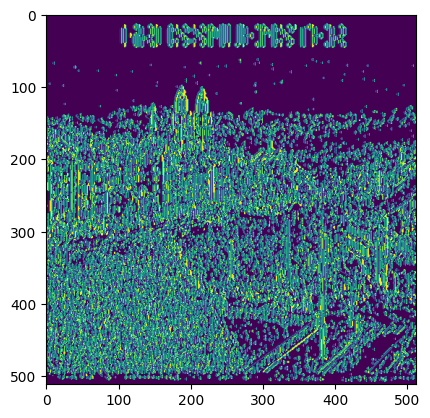

In [6]:
height, width = image.shape

#creating A
A = np.zeros((height, width, 2, 2))

# for each pixel
A[:, :, 0, 0] = Ix2_sobel_conj  # \bar{I_x^2}
A[:, :, 0, 1] = Ixy_conj         # \bar{I_x I_y}
A[:, :, 1, 0] = Ixy_conj         # \bar{I_x I_y}
A[:, :, 1, 1] = Iy2_sobel_conj   # \bar{I_y^2}

print(A.shape)
plt.imshow(A[:, :, 0, 0])
plt.show()

In [ ]:
k = 0.04

H = np.zeros((height, width))

for i in range(height):
    for j in range(width):
        #det(A_ij)
        det_Aij = np.linalg.det(A[i, j])

        # trace(A_ij)
        trace_Aij = np.trace(A[i, j])

        # réponse Harris
        H[i, j] = det_Aij - k * (trace_Aij ** 2)


#det_A = (Ix2_sobel_conj*Iy2_sobel_conj)-(Ixy_conj**2)
#trace_A=Ix2_sobel_conj+Iy2_sobel_conj
#Hrep = det_A - k* (trace_A **2)

#H_normalized = cv2.normalize(H, None, 0, 255, cv2.NORM_MINMAX)

# Afficher la réponse Harris normalisée

cv2.imshow('Harris Response',H.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()

"""
concatenated = np.hstack((H_normalized.astype(np.uint8), H.astype(np.uint8)))
cv2.imshow('Harris Responses normalisee  et non normalisee', concatenated)
"""
"""
la fenêtre créée avec cv2.imshow() serait instantanément fermée après son ouverture,
car le programme ne mettrait pas en pause pour permettre à l'utilisateur de voir l'image
donc il faut un WAIT
"""

cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
threshold = 50000

corners = np.zeros_like(H)

window_size = 3
offset = window_size // 2  # Décalage de la fenêtre


for i in range(offset, H.shape[0] ):
    for j in range(offset, H.shape[1]):
        #H(i, j) dépasse le seuil?
        if H[i, j] > threshold:
            # Extraire la fenêtre de voisins autour du pixel (i, j)
            window = H[i-offset:i+offset+1, j-offset:j+offset+1]

            # H[i, j] est le maximum local?
            if H[i, j] == np.max(window):
                # Si oui
                corners[i, j] = 255

max_value = np.max(H)
print(max_value)
cv2.imshow('Detected Corners', corners.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()



# 2 Canny Edge Detection 

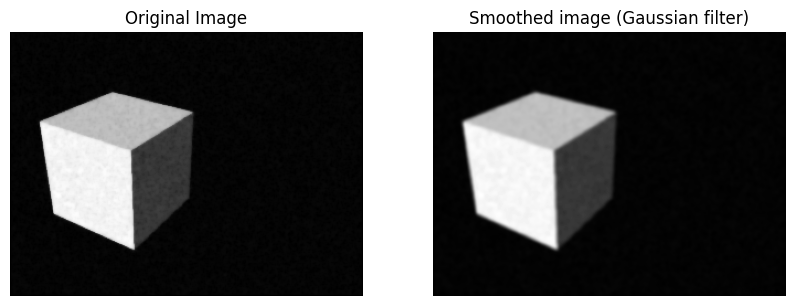

In [4]:
# read the image
image2 = cv2.imread("Images/cube_right.pgm", cv2.IMREAD_GRAYSCALE)

# Computing smoothed image
smoothed_image = cv2.GaussianBlur(image2, (5, 5), sigmaX=1.4)

# Plotting the image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image2, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Smoothed image (Gaussian filter)')
plt.imshow(smoothed_image, cmap='gray')
plt.axis('off')

plt.show()

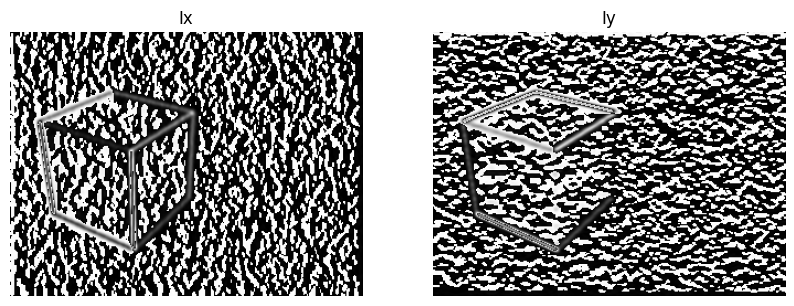

In [9]:
#computing Ix and Iy with sobel matrix
Ix = convolve(smoothed_image, sobel_x)
Iy = convolve(smoothed_image, sobel_y)

# Plotting the image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Ix')
plt.imshow(Ix, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Iy')
plt.imshow(Iy, cmap='gray')
plt.axis('off')

plt.show()

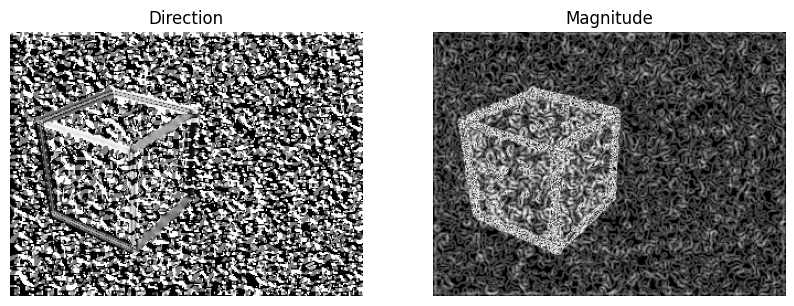

In [10]:
# Computing direction
direction = np.arctan2(Iy, Ix)

# Computing magnitude
magnitude = np.sqrt(Ix**2 + Iy**2)

# Plotting direction and magnitude
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Direction')
plt.imshow(direction, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Magnitude')
plt.imshow(magnitude, cmap='gray')
plt.axis('off')

plt.show()

* Non maximum suppresion

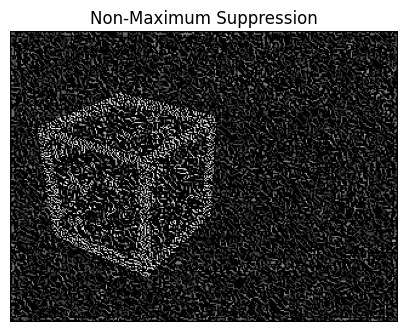

In [12]:
# the new matrix to keep
suppressed = np.zeros_like(magnitude)

# Get the dimensions of the image
height, width = magnitude.shape

# Iterate over every pixel except the border
for i in range(1, height-1):
    for j in range(1, width-1):
        
        # Get the angle of the gradient
        angle = direction[i, j]
        
        # Determine the neighbors to compare to based on the gradient direction
        
        if (-np.pi / 8 <= angle < np.pi / 8) or (7 * np.pi / 8 <= angle) or (angle < -7 * np.pi / 8):
            # Gradient direction is horizontal (0 degrees), so compare to vertical neighbors
            neighbor1 = magnitude[i + 1, j] # we take above and below the pixel
            neighbor2 = magnitude[i - 1, j]
            
        elif (np.pi / 8 <= angle < 3 * np.pi / 8) or (-7 * np.pi / 8 <= angle < -5 * np.pi / 8):
            # Gradient direction is -45 degrees, so compare to diagonal neighbors (bottom-left to top-right)
            neighbor1 = magnitude[i + 1, j - 1] # we take top-left and bottom-right
            neighbor2 = magnitude[i - 1, j + 1]
            
        elif (3 * np.pi / 8 <= angle < 5 * np.pi / 8) or (-5 * np.pi / 8 <= angle < -3 * np.pi / 8):
            # Gradient direction is vertical (90 degrees), so compare to horizontal neighbors
            neighbor1 = magnitude[i, j + 1]   # we take left and right pixel
            neighbor2 = magnitude[i, j - 1]
            
        else:
            # Gradient direction is 45 degrees, so compare to diagonal neighbors (top-left to bottom-right)
            neighbor1 = magnitude[i - 1, j - 1]  # we take bottom-left and top-right
            neighbor2 = magnitude[i + 1, j + 1]
        
        # Keep the pixel if its magnitude is greater than both its neighbors
        if magnitude[i, j] >= neighbor1 and magnitude[i, j] >= neighbor2:
            suppressed[i, j] = magnitude[i, j]



# Plotting the result of non-maximum suppression
plt.figure(figsize=(5, 5))
plt.title('Non-Maximum Suppression')
plt.imshow(suppressed, cmap='gray')
plt.axis('off')
plt.show()